<a href="https://colab.research.google.com/github/anushapalisetty/Intel-Image-Classification/blob/main/Inception_of_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import random as rn
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers,Model
from tensorflow.keras.optimizers import RMSprop,Adam

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path="/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_train/seg_train/"

In [6]:
def loadImages(path,classes):
    '''Put files into lists and return them as one list with all images 
     in the folder'''
    image_files = sorted([os.path.join(path, classes, file)
                          for file in os.listdir(path + classes)
                          if file.endswith('.jpg')])
    return image_files

In [7]:
classes=['buildings', 'forest' , 'glacier' , 'mountain', 'sea', 'street']
classes1=['buildings', 'forest' , 'glacier' , 'mountain', 'sea', 'street']
for i in range(len(classes)):
  classes1[i]=loadImages(path,classes[i])
  print(f'length of {classes[i]} is {len(classes1[i])}')

length of buildings is 2200
length of forest is 2281
length of glacier is 2404
length of mountain is 2522
length of sea is 2284
length of street is 2382


In [8]:
%time
build_img = [cv2.imread(i, cv2.IMREAD_UNCHANGED) for i in classes1[4][:20]]

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


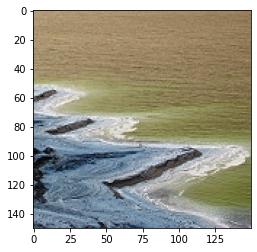

In [9]:
plt.imshow(build_img[13])

In [10]:
build_img[3].shape

(150, 150, 3)

In [11]:
## Data Generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2, horizontal_flip=True,shear_range=0.2,
    zoom_range=0.2, validation_split=0.1)
#test_datagen = ImageDataGenerator(rescale = 1./255.)
test_datagen = ImageDataGenerator()

In [13]:
train_data_generator=train_datagen.flow_from_directory(
      '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_train/seg_train/',
      target_size=(150,150),
      batch_size=32,
      class_mode='categorical',
      seed=2000,
      subset='training'
    
)

validation_data_generator=train_datagen.flow_from_directory(
      '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_train/seg_train/',
      target_size=(150,150),
      batch_size=32,
      class_mode='categorical',
      seed=2000,
      subset='validation'
    
)

test_data_generator=test_datagen.flow_from_directory(
      '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_test/seg_test/',
      target_size=(150,150),
      batch_size=32,
       class_mode='categorical',
       shuffle = False,
      seed=2000
)

Found 12667 images belonging to 6 classes.
Found 1406 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [14]:
inception_v3_model=InceptionV3(include_top=False, weights="imagenet",  input_shape=(150,150,3))
inception_v3_model.trainable = False

87916544/87910968 [==============================] - 1s 0us/step


In [18]:
def compile_model(pre_trained_model, cut_layer):
  last_layer = pre_trained_model.get_layer(cut_layer)
  last_output = last_layer.output

  x = layers.Flatten()(last_output)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(512, activation='relu')(x)
  #x = layers.Dropout(0.5)(x)                  
  x = layers.Dense(6, activation='softmax')(x)           

  model = Model(pre_trained_model.input, x)
  initial_learning_rate = 0.1
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
  model.compile(optimizer = Adam(learning_rate=0.0001), 
                loss = 'categorical_crossentropy', 
                metrics = ['accuracy'])
  return model

transfered_inception_v3_model = compile_model(inception_v3_model, 'mixed7')

In [19]:
transfered_inception_v3_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [20]:
#reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, mode='auto')
history_inception_v3 = transfered_inception_v3_model.fit(
                            train_data_generator,
                            validation_data = validation_data_generator,
                            #callbacks=[reduce],
                            epochs = 30)
        

Epoch 1/30
396/396 [==============================] - 623s 2s/step - loss: 0.4883 - accuracy: 0.8220 - val_loss: 0.4110 - val_accuracy: 0.8506
Epoch 2/30
396/396 [==============================] - 622s 2s/step - loss: 0.3914 - accuracy: 0.8572 - val_loss: 0.3630 - val_accuracy: 0.8684
Epoch 3/30
396/396 [==============================] - 614s 2s/step - loss: 0.3498 - accuracy: 0.8735 - val_loss: 0.3314 - val_accuracy: 0.8855
Epoch 4/30
396/396 [==============================] - 615s 2s/step - loss: 0.3395 - accuracy: 0.8741 - val_loss: 0.3371 - val_accuracy: 0.8834
Epoch 5/30
396/396 [==============================] - 621s 2s/step - loss: 0.3276 - accuracy: 0.8762 - val_loss: 0.3054 - val_accuracy: 0.8926
Epoch 6/30
396/396 [==============================] - 615s 2s/step - loss: 0.3178 - accuracy: 0.8806 - val_loss: 0.3132 - val_accuracy: 0.8926
Epoch 7/30
396/396 [==============================] - 619s 2s/step - loss: 0.3106 - accuracy: 0.8842 - val_loss: 0.3226 - val_accuracy: 0.8926

In [21]:
transfered_inception_v3_model.save('/content/drive/My Drive/Colab Notebooks/DL_Project_Data/InceptionV3_v1_30Ep.hd5')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/DL_Project_Data/InceptionV3_v1_30Ep.hd5/assets


In [22]:
import pandas as pd
df_incpnet = pd.DataFrame(history_inception_v3.history)      
# saving the dataframe  
df_incpnet.to_csv('/content/drive/My Drive/Colab Notebooks/DL_Project_Data/InceptionNET_30E_History.csv')  

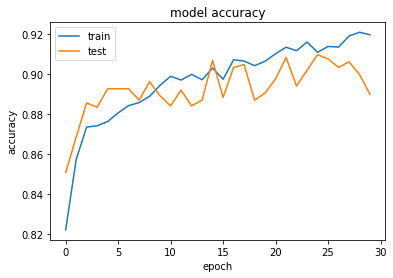

In [23]:
# summarize history for accuracy
plt.plot(history_inception_v3.history['accuracy'])
plt.plot(history_inception_v3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

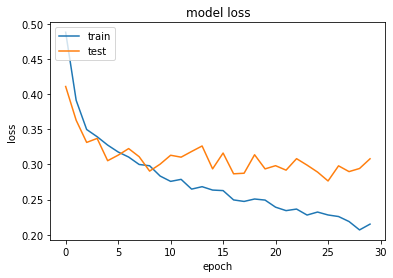

In [24]:
plt.plot(history_inception_v3.history['loss'])
plt.plot(history_inception_v3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
model=transfered_inception_v3_model
#model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/DL_Project_Data/IIC_Inception.hd5')
#model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/DL_Project_Data/model.hd5')

In [28]:
accuracy=model.evaluate_generator(test_data_generator,steps=len(test_data_generator) //64,verbose=2)
print('Accuracy of the model on the test set: ',accuracy[1])
accuracy

1/1 - 0s - loss: 121.7583 - accuracy: 0.1875
Accuracy of the model on the test set:  0.1875


[121.75825500488281, 0.1875]

In [30]:
accuracy1=transfered_inception_v3_model.evaluate_generator(validation_data_generator,steps=len(validation_data_generator) //32,verbose=2)
print('Accuracy of the model on the test set: ',accuracy1[1])
accuracy1

1/1 - 0s - loss: 0.3663 - accuracy: 0.9375
Accuracy of the model on the test set:  0.9375


[0.3662833869457245, 0.9375]

In [ ]:
img= '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_pred/seg_pred/georgia-state-university-1.png'
#img= '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_pred/seg_pred/Anusha-Sea.jpeg'
#img= '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_pred/seg_pred/Pooru-Mountain.jpeg'

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
img=cv2.imread(img)
img=cv2.resize(img, (224,224))
plt.imshow(img.reshape([224,224,3]))
img = np.reshape(img,[1,224,224,3])

In [ ]:
model.predict(img).round(2)

In [ ]:
#probabilities = model.predict_generator(test_data_generator, 3000)

In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_pred/seg_pred/'
images = []

x = os.listdir("/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_pred/seg_pred/")

for i in x:
    img = path + i
    images.append(img)

In [ ]:
labels = {
    0 : "buildings" , 
    1 : "forest" , 
    2 : "glacier" , 
    3 : "mountain" , 
    4 : "sea" , 
    5 : "street"
}

In [ ]:
from tensorflow.keras.preprocessing import image

outputs = []
ids = []
for i in images:
    img = image.load_img(i , target_size = (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img , axis=0)
    c = model.predict([img])
    pred_labels = np.argmax(c, axis = 1)
    la = labels[pred_labels[0]]
    
    outputs.append(la)
    ids.append(i)


In [ ]:
import pandas as pd
data = pd.DataFrame({
    "Image" : ids , 
    "Label" : outputs
})

In [ ]:
pd.options.display.max_colwidth=100
data

In [ ]:
data.Label.value_counts()

In [ ]:
data.Label.value_counts()

In [ ]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
['buildings', 'forest' , 'glacier' , 'mountain', 'sea', 'street']